In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
#! pip install -q tensorflow-datasets

# Getting the data

###### There's a library called TensorFlow Data Services or TFTS for short, and that contains many data sets and lots of different categories. This dataset is ideal because it contains a large body of texts, 50,000 movie reviews which are categorized as positive or negative. It was authored by Andrew Mass et al at Stanford (http://ai.stanford.edu/~amaas/data/sentiment/)

###### Now, you can import TensorFlow datasets, and in this case I call them tfds. With imdb reviews, I can now call tfds.load, pass it the string imdb reviews, and it will return the data from imdb, and metadata about it with this code.

In [3]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

#####  The data is split into 25,000 samples for training and 25,000 samples for testing. I can split them out like this.Each of these are iterables containing the 25,000 respective sentences and labels as tensors. As we will use kera's tokenizers and padding tools on arrays of sentences, we need to do a little converting. 

In [4]:
train_data, test_data = imdb['train'], imdb['test']

#####  First of all, let's define the lists containing the sentences and labels for both training and testing data. 

In [5]:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

##### Now, I can iterate over training data extracting the sentences and the labels. The values for S and I are tensors, so by calling their NumPy method, I'll actually extract their value. Then I'll do the same for the test set. When training, my labels are expected to be NumPy arrays. So I'll turn the list of labels that I've just created into NumPy arrays.

In [6]:
# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

In [7]:
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

In [8]:
training_labels_final = np.array(training_labels)

In [9]:
testing_labels_final = np.array(testing_labels)

# Pre-processing

###### Next up, we'll tokenize our sentences. First I set the hyperparameters.

In [10]:
vocab_size = 10000 
embedding_dim = 16
max_length = 120 
trunc_type='post'
oov_tok = "<OOV>"

###### We create an instance of tokenizer, giving it our vocab size and our desired out of vocabulary token. 

In [11]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

###### We'll now fit the tokenizer on our training set of data.

In [12]:
tokenizer.fit_on_texts(training_sentences)

###### We get the index

In [13]:
word_index = tokenizer.word_index

###### Once we have our word index, we can now replace the strings containing the words with the token value we created for them. This will be the list called sequences. As before, the sentences will have variant length. So we'll pad and or truncate the sequenced sentences until they're all the same length, determined by the maxlength parameter. 

In [14]:
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

##### Then we'll do the same for the testing sequences. Note that the word index is words that are derived from the training set, so you should expect to see a lot more out of vocabulary tokens in the test exam.

In [15]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

##### So I can now explore what this looks like. So for example here you can see I've just taken my reverse word index, and I can decode my review by taking a look at the numbers in that review and reversing that into a word. So taking the key for that value and reverse word index flips the key value pair. 

In [16]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you <OOV> into a big arm chair and <OOV> for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no <OOV> to cross no dangerous waters just a warm and witty <OOV> through new york life at its best a family film in every sense and one that deserves the praise it received


In [17]:
print(training_sentences[3])

This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.


# Model

#####  Now it's time to define our neural network. Here emebeding is where the magic happens. So in a movie review, it might say that the movie was dull and boring, or it might say that it was fun and exciting. So what if you could pick a vector in a higher-dimensional space say 16 dimensions, and words that are found together are given similar vectors. Then over time, words can begin to cluster together. The meaning of the words can come from the labeling of the dataset. So in this case, we say a negative review and the words dull and boring show up a lot in the negative review so that they have similar sentiments, and they are close to each other in the sentence. Thus their vectors will be similar. As the neural network trains, it can then learn these vectors associating them with the labels to come up with what's called an embedding i.e., the vectors for each word with their associated sentiment. The results of the embedding will be a 2D array with the length of the sentence and the embedding dimension for example 16 as its size.

### model a)

###### We then feed that into a dense neural network to do the classification. Often in natural language processing, a different layer type than a flatten is used, and this is a global average pooling 1D as tf.keras.layers.GlobalAveragePooling1D()

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [19]:
num_epochs = 10
history=model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 4s 4ms/step - loss: 0.4918 - accuracy: 0.7450 - val_loss: 0.3634 - val_accuracy: 0.8364
Epoch 2/10
782/782 [==============================] - 3s 3ms/step - loss: 0.2347 - accuracy: 0.9106 - val_loss: 0.4049 - val_accuracy: 0.8266
Epoch 3/10
782/782 [==============================] - 3s 3ms/step - loss: 0.0839 - accuracy: 0.9795 - val_loss: 0.4925 - val_accuracy: 0.8152
Epoch 4/10
782/782 [==============================] - 3s 3ms/step - loss: 0.0202 - accuracy: 0.9980 - val_loss: 0.5351 - val_accuracy: 0.8253
Epoch 5/10
782/782 [==============================] - 3s 3ms/step - loss: 0.0046 - accuracy: 0.9999 - val_loss: 0.6014 - val_accuracy: 0.8248
Epoch 6/10
782/782 [==============================] - 3s 3ms/step - loss: 0.0020 - accuracy: 0.9999 - val_loss: 0.6488 - val_accuracy: 0.8253
Epoch 7/10
782/782 [==============================] - 3s 3ms/step - loss: 0.0010 - accuracy: 0.9999 - val_loss: 0.6934 - val_accuracy: 0.8258
Epoch 

In [20]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


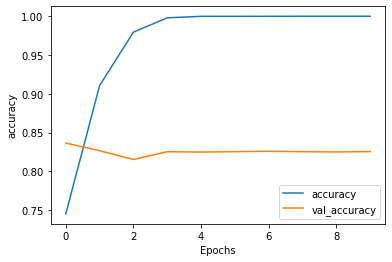

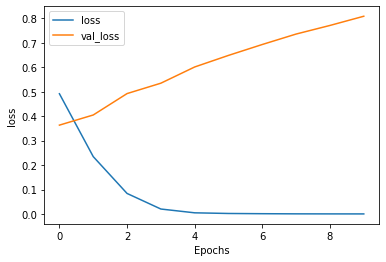

In [21]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### model b)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


In [23]:
num_epochs = 10
history=model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 3s 4ms/step - loss: 0.5766 - accuracy: 0.7522 - val_loss: 0.4171 - val_accuracy: 0.8360
Epoch 2/10
782/782 [==============================] - 3s 4ms/step - loss: 0.3553 - accuracy: 0.8560 - val_loss: 0.3392 - val_accuracy: 0.8553
Epoch 3/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2874 - accuracy: 0.8827 - val_loss: 0.3281 - val_accuracy: 0.8591
Epoch 4/10
782/782 [==============================] - 3s 3ms/step - loss: 0.2500 - accuracy: 0.9006 - val_loss: 0.3306 - val_accuracy: 0.8577
Epoch 5/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2233 - accuracy: 0.9146 - val_loss: 0.3510 - val_accuracy: 0.8513
Epoch 6/10
782/782 [==============================] - 4s 4ms/step - loss: 0.2018 - accuracy: 0.9244 - val_loss: 0.3611 - val_accuracy: 0.8492
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 0.1835 - accuracy: 0.9346 - val_loss: 0.3946 - val_accuracy: 0.8412
Epoch 

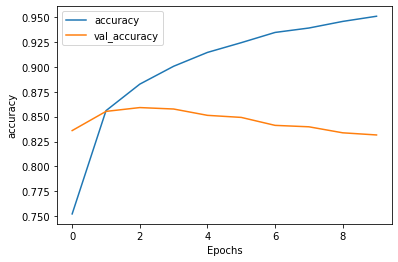

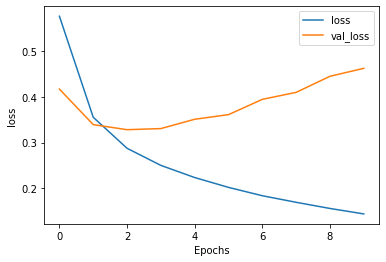

In [24]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### model c) 

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [26]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 55s 66ms/step - loss: 0.5925 - accuracy: 0.6968 - val_loss: 0.4627 - val_accuracy: 0.8219
Epoch 2/50
782/782 [==============================] - 48s 61ms/step - loss: 0.4047 - accuracy: 0.8559 - val_loss: 0.4019 - val_accuracy: 0.8424
Epoch 3/50
782/782 [==============================] - 47s 61ms/step - loss: 0.3165 - accuracy: 0.8912 - val_loss: 0.4109 - val_accuracy: 0.8367
Epoch 4/50
782/782 [==============================] - 47s 61ms/step - loss: 0.2580 - accuracy: 0.9145 - val_loss: 0.4521 - val_accuracy: 0.8336
Epoch 5/50
782/782 [==============================] - 47s 61ms/step - loss: 0.2127 - accuracy: 0.9328 - val_loss: 0.4706 - val_accuracy: 0.8315
Epoch 6/50
782/782 [==============================] - 48s 61ms/step - loss: 0.1777 - accuracy: 0.9464 - val_loss: 0.5487 - val_accuracy: 0.8268
Epoch 7/50
782/782 [==============================] - 47s 60ms/step - loss: 0.1537 - accuracy: 0.9554 - val_loss: 0.5882 - val_accuracy:

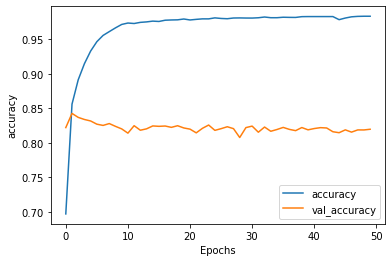

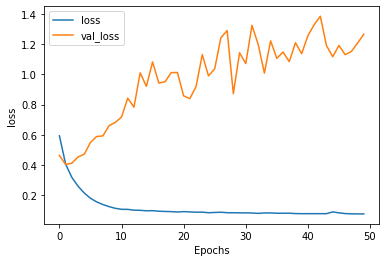

In [27]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### model d)

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [29]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 48s 58ms/step - loss: 0.4723 - accuracy: 0.7665 - val_loss: 0.3618 - val_accuracy: 0.8389
Epoch 2/50
782/782 [==============================] - 46s 59ms/step - loss: 0.2950 - accuracy: 0.8796 - val_loss: 0.3513 - val_accuracy: 0.8460
Epoch 3/50
782/782 [==============================] - 45s 57ms/step - loss: 0.2403 - accuracy: 0.9054 - val_loss: 0.3715 - val_accuracy: 0.8410
Epoch 4/50
782/782 [==============================] - 47s 60ms/step - loss: 0.1975 - accuracy: 0.9248 - val_loss: 0.4191 - val_accuracy: 0.8351
Epoch 5/50
782/782 [==============================] - 46s 58ms/step - loss: 0.1646 - accuracy: 0.9392 - val_loss: 0.4737 - val_accuracy: 0.8260
Epoch 6/50
782/782 [==============================] - 55s 70ms/step - loss: 0.1419 - accuracy: 0.9476 - val_loss: 0.5206 - val_accuracy: 0.8282
Epoch 7/50
782/782 [==============================] - 45s 58ms/step - loss: 0.1111 - accuracy: 0.9610 - val_loss: 0.5616 - val_accuracy:

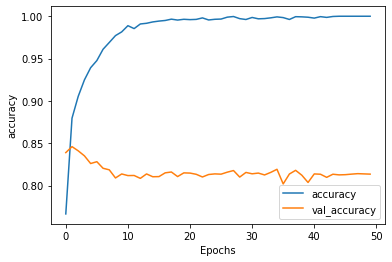

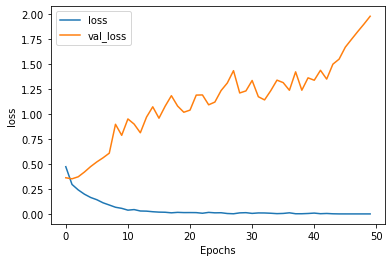

In [30]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### model e)

In [31]:
# Model Definition with Conv1D
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________


In [32]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 8s 9ms/step - loss: 0.4661 - accuracy: 0.7670 - val_loss: 0.3501 - val_accuracy: 0.8458
Epoch 2/50
782/782 [==============================] - 7s 9ms/step - loss: 0.2849 - accuracy: 0.8834 - val_loss: 0.3600 - val_accuracy: 0.8435
Epoch 3/50
782/782 [==============================] - 7s 9ms/step - loss: 0.2303 - accuracy: 0.9108 - val_loss: 0.3844 - val_accuracy: 0.8386
Epoch 4/50
782/782 [==============================] - 7s 9ms/step - loss: 0.1932 - accuracy: 0.9281 - val_loss: 0.4262 - val_accuracy: 0.8292
Epoch 5/50
782/782 [==============================] - 7s 9ms/step - loss: 0.1604 - accuracy: 0.9432 - val_loss: 0.4840 - val_accuracy: 0.8236
Epoch 6/50
782/782 [==============================] - 7s 9ms/step - loss: 0.1307 - accuracy: 0.9561 - val_loss: 0.5496 - val_accuracy: 0.8217
Epoch 7/50
782/782 [==============================] - 7s 9ms/step - loss: 0.1017 - accuracy: 0.9676 - val_loss: 0.6149 - val_accuracy: 0.8130
Epoch 

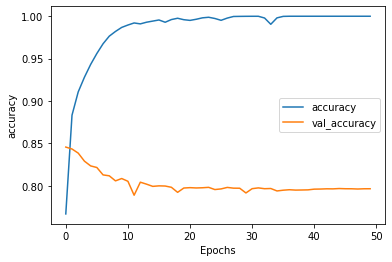

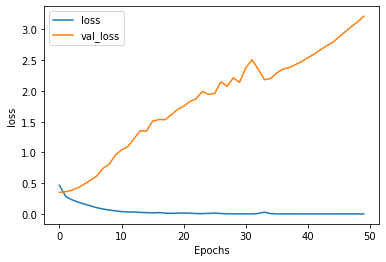

In [33]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### model f) with a pre-tokenize dataset

# Getting data

In [34]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

In [35]:
train_data, test_data = imdb['train'], imdb['test']

In [36]:
# To access to the sub words tokenizer 
tokenizer = info.features['text'].encoder

In [37]:
# We have a pre-trained sub-words now, so we can inspect its vocabulary by looking at its sub-words property. 
print(tokenizer.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [38]:
#If we want to see how it encodes or decode strings, we can do so with this code 
sample_string = 'TensorFlow, from basics to mastery'

#So, we can encode by simple calling the encode method passing it the string 
tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

# SImilarly, decode by calling the decode method 
original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


In [39]:
# If we want to see the tokens themselves , we can take each element and decode that showing the value to token 
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


In [40]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

In [41]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 390       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


In [42]:
num_epochs = 10

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 14s 33ms/step - loss: 0.6760 - accuracy: 0.6043 - val_loss: 0.6224 - val_accuracy: 0.7406
Epoch 2/10
391/391 [==============================] - 12s 30ms/step - loss: 0.5105 - accuracy: 0.8018 - val_loss: 0.4411 - val_accuracy: 0.8287
Epoch 3/10
391/391 [==============================] - 12s 30ms/step - loss: 0.3607 - accuracy: 0.8723 - val_loss: 0.3552 - val_accuracy: 0.8667
Epoch 4/10
391/391 [==============================] - 12s 30ms/step - loss: 0.2921 - accuracy: 0.8972 - val_loss: 0.3256 - val_accuracy: 0.8746
Epoch 5/10
391/391 [==============================] - 12s 30ms/step - loss: 0.2562 - accuracy: 0.9082 - val_loss: 0.3122 - val_accuracy: 0.8790
Epoch 6/10
391/391 [==============================] - 12s 30ms/step - loss: 0.2294 - accuracy: 0.9187 - val_loss: 0.3153 - val_accuracy: 0.8762
Epoch 7/10
391/391 [==============================] - 12s 30ms/step - loss: 0.2108 - accuracy: 0.9249 - val_loss: 0.3068 - val_accuracy:

In [43]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

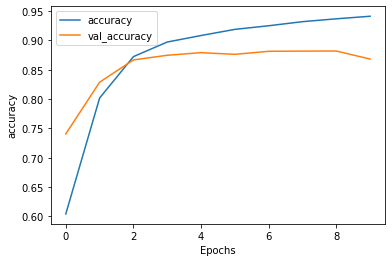

In [44]:
plot_graphs(history, "accuracy")

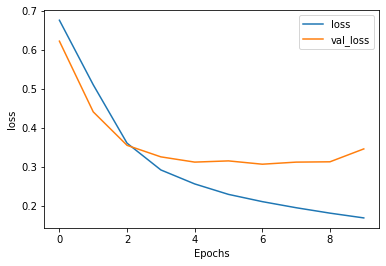

In [45]:
plot_graphs(history, "loss")

### model h)

In [46]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size,64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


In [47]:
NUM_EPOCHS = 10
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 596s 2s/step - loss: 0.5453 - accuracy: 0.7278 - val_loss: 0.4987 - val_accuracy: 0.7744
Epoch 2/10
391/391 [==============================] - 600s 2s/step - loss: 0.3610 - accuracy: 0.8540 - val_loss: 0.4089 - val_accuracy: 0.8310
Epoch 3/10
391/391 [==============================] - 584s 1s/step - loss: 0.2992 - accuracy: 0.8838 - val_loss: 0.4432 - val_accuracy: 0.7982
Epoch 4/10
391/391 [==============================] - 578s 1s/step - loss: 0.3480 - accuracy: 0.8521 - val_loss: 0.4333 - val_accuracy: 0.8291
Epoch 5/10
391/391 [==============================] - 603s 2s/step - loss: 0.2421 - accuracy: 0.9120 - val_loss: 0.4014 - val_accuracy: 0.8306
Epoch 6/10
391/391 [==============================] - 583s 1s/step - loss: 0.2129 - accuracy: 0.9208 - val_loss: 0.4533 - val_accuracy: 0.8328
Epoch 7/10
391/391 [==============================] - 589s 2s/step - loss: 0.2025 - accuracy: 0.9250 - val_loss: 0.5112 - val_accuracy: 0.8053

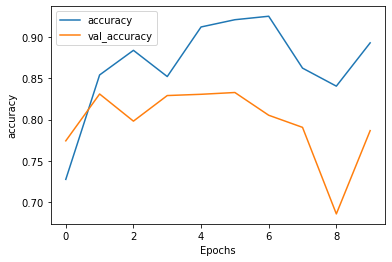

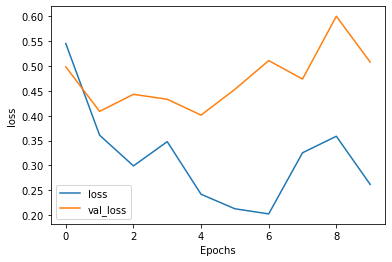

In [48]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### model i)

In [49]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size,64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),# When you feed the LSTM into other one you need to put the return sequencesequal true,this makes sure that the outputs of the LSTM matchthe desired inputs of the next one
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 635,329
Trainable params: 635,329
Non-trainable params: 0
_________________________________________________________________


In [50]:
NUM_EPOCHS = 10
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 1091s 3s/step - loss: 0.5575 - accuracy: 0.7133 - val_loss: 0.6268 - val_accuracy: 0.6954
Epoch 2/10
391/391 [==============================] - 1084s 3s/step - loss: 0.4109 - accuracy: 0.8258 - val_loss: 0.4319 - val_accuracy: 0.8200
Epoch 3/10
391/391 [==============================] - 1075s 3s/step - loss: 0.4569 - accuracy: 0.7984 - val_loss: 0.4896 - val_accuracy: 0.7992
Epoch 4/10
391/391 [==============================] - 1090s 3s/step - loss: 0.3378 - accuracy: 0.8635 - val_loss: 0.4145 - val_accuracy: 0.8151
Epoch 5/10
391/391 [==============================] - 1075s 3s/step - loss: 0.2509 - accuracy: 0.9030 - val_loss: 0.3736 - val_accuracy: 0.8299
Epoch 6/10
391/391 [==============================] - 1089s 3s/step - loss: 0.2036 - accuracy: 0.9262 - val_loss: 0.3284 - val_accuracy: 0.8638
Epoch 7/10
391/391 [==============================] - 1079s 3s/step - loss: 0.1655 - accuracy: 0.9428 - val_loss: 0.3527 - val_accuracy:

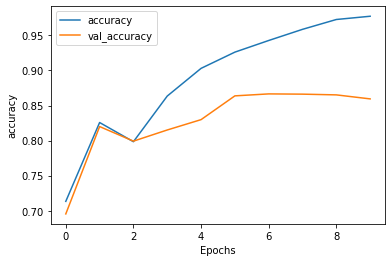

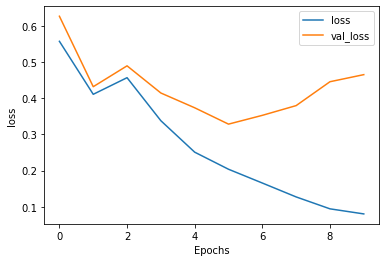

In [51]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")